In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.dates as mdates
from matplotlib import font_manager, rc
# 행렬 연산 패키지
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 통계 분석 패키지
from scipy import stats
import scipy.stats
import datetime
import warnings

warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['font.family'] = 'NanumGothic Eco' 

훈련 데이터 개수: 90
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=635.007, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=689.605, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=667.990, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=632.684, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=687.645, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=634.417, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=634.317, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=633.989, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=634.779, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.720 seconds
Best (p, d, q) parameters: (0, 1, 1)


ValueError: x and y must have same first dimension, but have shapes (31,) and (10,)

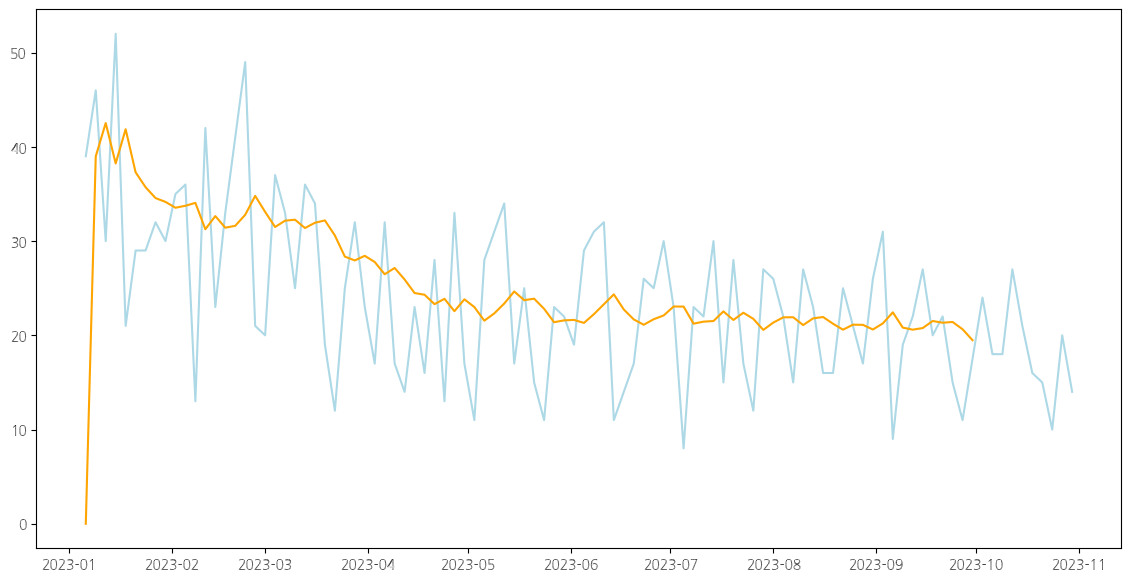

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# 데이터 불러오기 및 날짜 변환
data = pd.read_csv("/home/piai/RFM_product.csv", encoding='euc-kr')
data['날짜'] = pd.to_datetime(data['날짜'])

# '구매 매장'이 'C'이고 '물품 소분류'가 '유정란'인 항목 필터링
c_store_egg_data = data[(data['구매매장'] == '매장C') & (data['물품소분류'] == '유정란')]

# 일별로 그룹화하여 판매 횟수 집계
c_store_egg_sales_daily = c_store_egg_data.groupby('날짜')['구매수량'].sum()


# 11월 데이터 제외
c_store_egg_sales_daily = c_store_egg_sales_daily[c_store_egg_sales_daily.index.month != 11]

# 인덱스에 3일 간격 설정 및 결측치 보간
c_store_egg_sales_daily = c_store_egg_sales_daily.asfreq('3D').interpolate(method='linear')

# 훈련 데이터와 테스트 데이터 분할 (12월까지 포함)
train_data = c_store_egg_sales_daily[:'2023-09-30']
test_data_length = (pd.to_datetime('2023-12-31') - pd.to_datetime('2023-10-01')).days // 3 + 1

# 훈련 데이터와 테스트 데이터 확인
print("훈련 데이터 개수:", len(train_data))

# 훈련 데이터가 제대로 생성되었는지 확인
if len(train_data) == 0:
    print("훈련 데이터가 없습니다. 날짜 범위를 다시 확인해 주세요.")
else:
    # auto_arima로 최적의 ARIMA 파라미터 찾기
    auto_model = auto_arima(train_data, seasonal=False, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)
    print("Best (p, d, q) parameters:", auto_model.order)

    # 최적의 (p, d, q) 값을 사용하여 ARIMA 모델 훈련
    model_fit = ARIMA(train_data, order=auto_model.order).fit()

    # Generate forecast dates to match the number of forecasted values
    forecast_dates = pd.date_range('2023-10-01', periods=test_data_length, freq='3D')

    # Plotting with corrected forecast dates
    plt.figure(figsize=(14, 7))
    plt.plot(c_store_egg_sales_daily.index, c_store_egg_sales_daily, color='lightblue', label='실제 데이터')
    plt.plot(train_data.index, model_fit.predict(start=train_data.index[0], end=train_data.index[-1]), color='orange', label='훈련 데이터 예측')
    plt.plot(forecast_dates, forecast_values, color='red', linestyle='--', label='10월~12월 예측')
    plt.fill_between(forecast_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
    plt.title('C 매장의 유정란 3일 간격 판매량 예측 (최적의 ARIMA 모델 사용)')
    plt.xlabel('구매 날짜')
    plt.ylabel('판매 횟수')
    plt.legend(loc='upper left')
    plt.grid()

    # x-axis ticks set to month intervals
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    

# 두 배열의 최소 길이 계산
min_length = min(len(test_data), len(forecast_values))

# 실제값과 예측값을 최소 길이에 맞춰 슬라이싱
comparison_df = pd.DataFrame({
    'Actual': test_data.values[:min_length],
    'Forecast': forecast_values[:min_length]
})

# 몇 개 일자에 대한 실제값과 예측값 출력 (예: 상위 10개)
print("Actual vs Forecast for Test Data:")
print(comparison_df.head(10))

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(comparison_df['Actual'], comparison_df['Forecast'])
print(f"Mean Absolute Error (MAE): {mae:.2f}")

In [34]:
# '날짜' 열을 datetime 형식으로 변환
data['날짜'] = pd.to_datetime(data['날짜'])

# '구매 매장'이 'C'이고 '물품 소분류'가 '유정란'인 항목 필터링
c_store_egg_data = data[(data['구매매장'] == '매장C') & (data['물품소분류'] == '유정란')]

# 일별로 그룹화하여 판매 횟수 집계
c_store_egg_sales_daily = c_store_egg_data.groupby(c_store_egg_data['날짜']).size()

# 11월 데이터 제외
c_store_egg_sales_daily = c_store_egg_sales_daily[c_store_egg_sales_daily.index.month != 11]

# 인덱스에 3일 간격 설정 및 결측치 보간
c_store_egg_sales_daily = c_store_egg_sales_daily.asfreq('3D').interpolate(method='linear')

# 수요가 낮은 임계값 설정 (예: 수요가 5 이하인 날을 찾고자 할 때)
threshold = 20

# 수요가 낮은 날 필터링
low_demand_days = c_store_egg_sales_daily[c_store_egg_sales_daily <= threshold]

# 요일별로 그룹화하여 수요가 낮은 날 개수 계산
low_demand_days_by_weekday = low_demand_days.groupby(low_demand_days.index.day_name()).size()

# 요일 순서 정렬 (선택사항: 요일을 월요일~일요일 순으로 정렬)
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
low_demand_days_by_weekday = low_demand_days_by_weekday.reindex(weekday_order)

# 결과 출력
print("수요가 낮은 날을 요일별로 구분한 결과:")
print(low_demand_days_by_weekday)

수요가 낮은 날을 요일별로 구분한 결과:
날짜
Monday        9
Tuesday       7
Wednesday    14
Thursday      1
Friday        5
Saturday      5
Sunday        9
dtype: int64


훈련 데이터 개수: 90
테스트 데이터 개수: 10
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=750.236, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=745.163, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=748.359, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=741.354, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=739.533, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=735.213, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=731.340, Time=0.22 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=705.224, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=704.778, Time=0.15 sec
 ARIMA(4,1,1)(0,0,0)[0]             : 

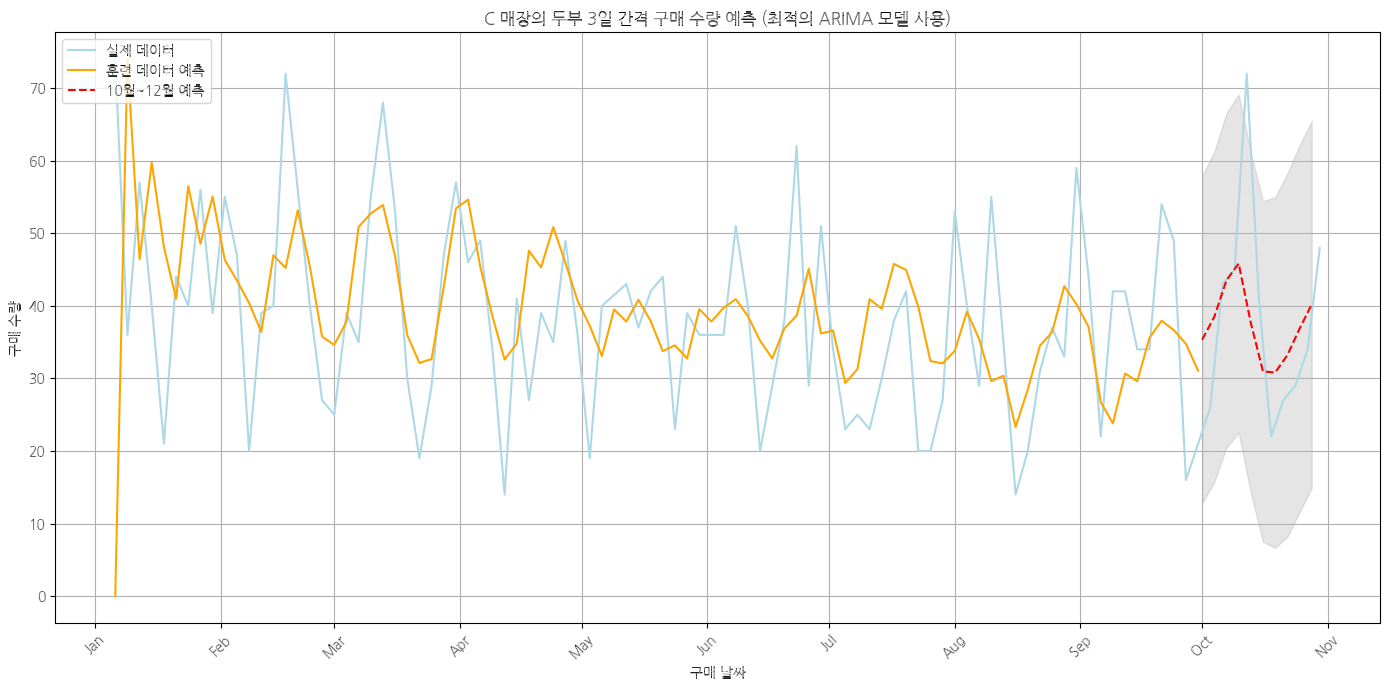

Actual vs Forecast for Test Data:
            Actual   Forecast
2023-10-03    26.0  35.325765
2023-10-06    43.0  38.495292
2023-10-09    45.0  43.531903
2023-10-12    72.0  45.830693
2023-10-15    41.0  37.654655
2023-10-18    22.0  30.959667
2023-10-21    27.0  30.812516
2023-10-24    29.0  33.195657
2023-10-27    34.0  36.826978
2023-10-30    48.0  40.184582
Mean Absolute Error (MAE): 7.24


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# 데이터 불러오기 및 날짜 변환
data = pd.read_csv("/home/piai/RFM_product.csv", encoding='euc-kr')
data['날짜'] = pd.to_datetime(data['날짜'])

# '구매 매장'이 'C'이고 '물품 소분류'가 '두부'인 항목 필터링
c_store_egg_data = data[(data['구매매장'] == '매장C') & (data['물품소분류'] == '두부')]

# 일별로 그룹화하여 구매 수량 합계 계산
c_store_egg_sales_daily = c_store_egg_data.groupby('날짜')['구매수량'].sum()

# 11월 데이터 제외
c_store_egg_sales_daily = c_store_egg_sales_daily[c_store_egg_sales_daily.index.month != 11]

# 3일 단위로 리샘플링 및 결측치 보간
c_store_egg_sales_daily = c_store_egg_sales_daily.asfreq('3D').interpolate(method='linear')

# 훈련 데이터와 테스트 데이터 분할 (3일 간격, 12월까지 포함)
train_data = c_store_egg_sales_daily[:'2023-09-30']
test_data = c_store_egg_sales_daily['2023-10-01':'2023-12-31']  # 3일 단위 데이터
test_data_length = len(test_data)

# 훈련 데이터와 테스트 데이터 확인
print("훈련 데이터 개수:", len(train_data))
print("테스트 데이터 개수:", len(test_data))

# 이후 과정은 동일하게 유지
if len(train_data) == 0:
    print("훈련 데이터가 없습니다. 날짜 범위를 다시 확인해 주세요.")
else:
    # auto_arima로 최적의 ARIMA 파라미터 찾기
    auto_model = auto_arima(train_data, seasonal=False, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)
    print("Best (p, d, q) parameters:", auto_model.order)

    # 최적의 (p, d, q) 값을 사용하여 ARIMA 모델 훈련
    model_fit = ARIMA(train_data, order=auto_model.order).fit()

    # 10월 1일부터 12월 31일까지 3일 간격으로 예측 수행
    forecast = model_fit.get_forecast(steps=test_data_length)
    forecast_values = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # 3일 간격으로 날짜 생성
    forecast_dates = pd.date_range('2023-10-01', periods=len(forecast_values), freq='3D')
    plt.figure(figsize=(14, 7))
    plt.plot(c_store_egg_sales_daily.index, c_store_egg_sales_daily, color='lightblue', label='실제 데이터')
    plt.plot(train_data.index, model_fit.predict(start=train_data.index[0], end=train_data.index[-1]), color='orange', label='훈련 데이터 예측')
    plt.plot(forecast_dates, forecast_values, color='red', linestyle='--', label='10월~12월 예측')
    plt.fill_between(forecast_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
    plt.title('C 매장의 두부 3일 간격 구매 수량 예측 (최적의 ARIMA 모델 사용)')
    plt.xlabel('구매 날짜')
    plt.ylabel('구매 수량')
    plt.legend(loc='upper left')
    plt.grid()

    # x축 눈금을 월별로 설정 (Jan ~ Dec)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 두 배열의 최소 길이 계산
min_length = min(len(test_data), len(forecast_values))

# 실제값과 예측값을 최소 길이에 맞춰 슬라이싱
comparison_df = pd.DataFrame({
    'Actual': test_data.values[:min_length],
    'Forecast': forecast_values[:min_length]
})

# 몇 개 일자에 대한 실제값과 예측값 출력 (예: 상위 10개)
print("Actual vs Forecast for Test Data:")
print(comparison_df.head(10))

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(comparison_df['Actual'], comparison_df['Forecast'])
print(f"Mean Absolute Error (MAE): {mae:.2f}")


In [6]:
# 두 배열의 최소 길이 계산
min_length = min(len(test_data), len(forecast_values))

# 실제값과 예측값을 최소 길이에 맞춰 슬라이싱
comparison_df = pd.DataFrame({
    'Actual': test_data.values[:min_length],
    'Forecast': forecast_values[:min_length]
})

# 몇 개 일자에 대한 실제값과 예측값 출력 (예: 상위 10개)
print("Actual vs Forecast for Test Data:")
print(comparison_df.head(10))

# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(comparison_df['Actual'], comparison_df['Forecast'])
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Actual vs Forecast for Test Data:
            Actual   Forecast
2023-10-03    26.0  35.325765
2023-10-06    43.0  38.495292
2023-10-09    45.0  43.531903
2023-10-12    72.0  45.830693
2023-10-15    41.0  37.654655
2023-10-18    22.0  30.959667
2023-10-21    27.0  30.812516
2023-10-24    29.0  33.195657
2023-10-27    34.0  36.826978
2023-10-30    48.0  40.184582
Mean Absolute Error (MAE): 7.24


In [7]:
# '날짜' 열을 datetime 형식으로 변환
data['날짜'] = pd.to_datetime(data['날짜'])

# '구매 매장'이 'C'이고 '물품 소분류'가 '두부'인 항목 필터링
c_store_tofu_data = data[(data['구매매장'] == '매장C') & (data['물품소분류'] == '두부')]

# 일별로 그룹화하여 판매 횟수 집계
c_store_tofu_sales_daily = c_store_tofu_data.groupby(c_store_tofu_data['날짜']).size()

# 11월 데이터 제외
c_store_tofu_sales_daily = c_store_tofu_sales_daily[c_store_tofu_sales_daily.index.month != 11]

# 인덱스에 3일 간격 설정 및 결측치 보간
c_store_tofu_sales_daily = c_store_tofu_sales_daily.asfreq('3D').interpolate(method='linear')

# 수요가 낮은 임계값 설정 (예: 수요가 5 이하인 날을 찾고자 할 때)
threshold = 20

# 수요가 낮은 날 필터링
low_demand_days = c_store_tofu_sales_daily[c_store_tofu_sales_daily <= threshold]

# 요일별로 그룹화하여 수요가 낮은 날 개수 계산
low_demand_days_by_weekday = low_demand_days.groupby(low_demand_days.index.day_name()).size()

# 요일 순서 정렬 (선택사항: 요일을 월요일~일요일 순으로 정렬)
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
low_demand_days_by_weekday = low_demand_days_by_weekday.reindex(weekday_order)

# 결과 출력
print("수요가 낮은 날을 요일별로 구분한 결과:")
print(low_demand_days_by_weekday)

수요가 낮은 날을 요일별로 구분한 결과:
날짜
Monday        NaN
Tuesday       1.0
Wednesday    14.0
Thursday      NaN
Friday        NaN
Saturday      4.0
Sunday        1.0
dtype: float64


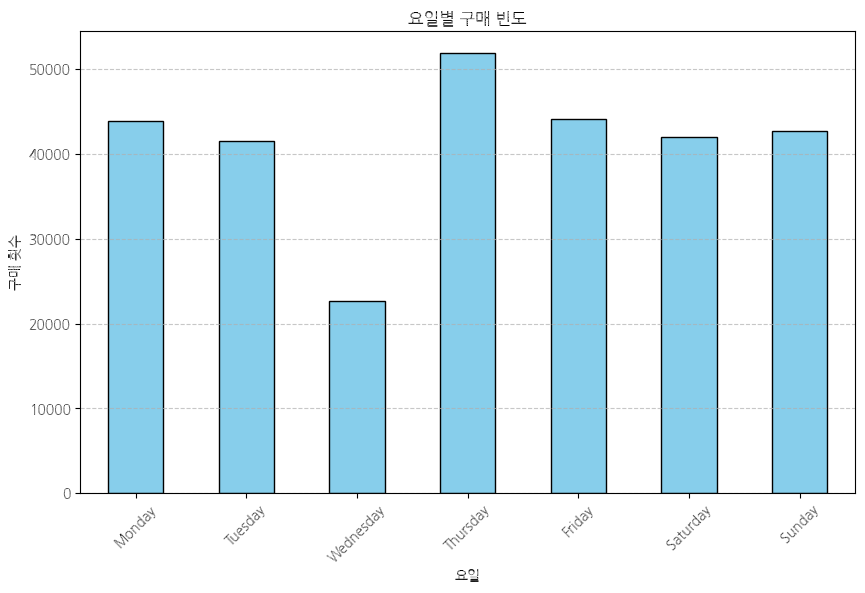

In [8]:
# '날짜' 열을 datetime 형식으로 변환
data['날짜'] = pd.to_datetime(data['날짜'])

# '날짜' 열에서 요일 정보 추출하여 새로운 열 추가
data['요일'] = data['날짜'].dt.day_name()

# 요일별 구매 횟수 집계
weekday_counts = data['요일'].value_counts().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# 요일별 구매 빈도 막대그래프 생성
plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('요일별 구매 빈도')
plt.xlabel('요일')
plt.ylabel('구매 횟수')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

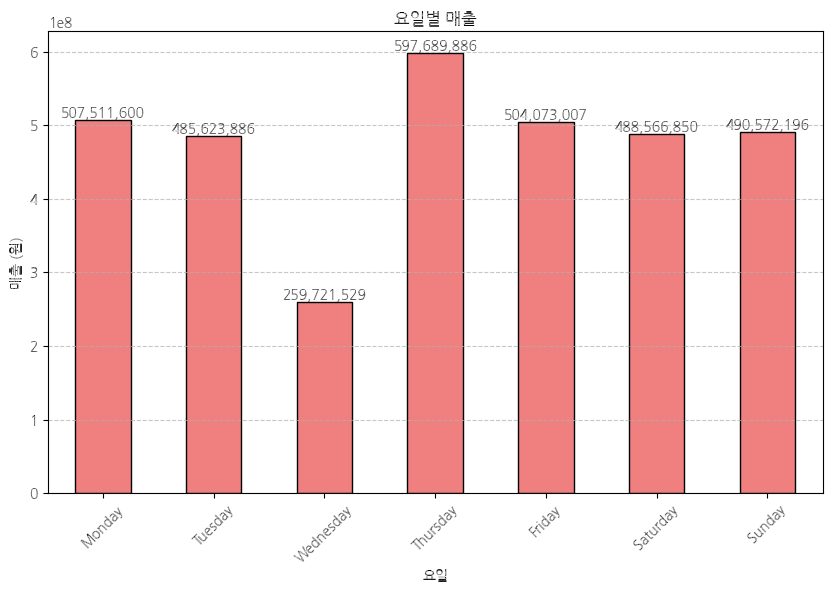

In [9]:
# '날짜' 열을 datetime 형식으로 변환
data['날짜'] = pd.to_datetime(data['날짜'])

# '날짜' 열에서 요일 정보 추출하여 새로운 열 추가
data['요일'] = data['날짜'].dt.day_name()

# 요일별 구매금액 합계 계산 (매출)
weekday_sales = data.groupby('요일')['구매금액'].sum().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# 요일별 매출 막대그래프 생성
plt.figure(figsize=(10, 6))
ax = weekday_sales.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('요일별 매출')
plt.xlabel('요일')
plt.ylabel('매출 (원)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 막대 위에 매출 금액 표시
for index, value in enumerate(weekday_sales):
    ax.annotate(f'{value:,.0f}', xy=(index, value), ha='center', va='bottom')

plt.show()